## Estadística Aplicada

Sesión 17 - 26 de octubre

Alexandra Guadalupe Valdez Mireles

Grupo 44

In [1]:
## Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Importar funciones de statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict 
from statsmodels.tsa.arima.model import ARIMA 

## Importar pmdarima para identificar orden del proceso
import pmdarima as pm 

In [3]:
## Importar los datos
desempleo_mex = pd.read_excel('desempleo_mex.xlsx')

In [4]:
desempleo_mex.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [5]:
desempleo_mex.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [6]:
## Verificar existencia de missing values
desempleo_mex.isnull().sum()

meses                0
tasa de desempleo    0
dtype: int64

In [7]:
## Formato fecha, Index, Frecuencia 

## Formato fecha 
desempleo_mex['meses'] = pd.to_datetime(desempleo_mex['meses'], format='%Y/%m')
## Index
desempleo_mex = desempleo_mex.set_index('meses')
## Frecuencia 
desempleo_mex = desempleo_mex.asfreq('MS')


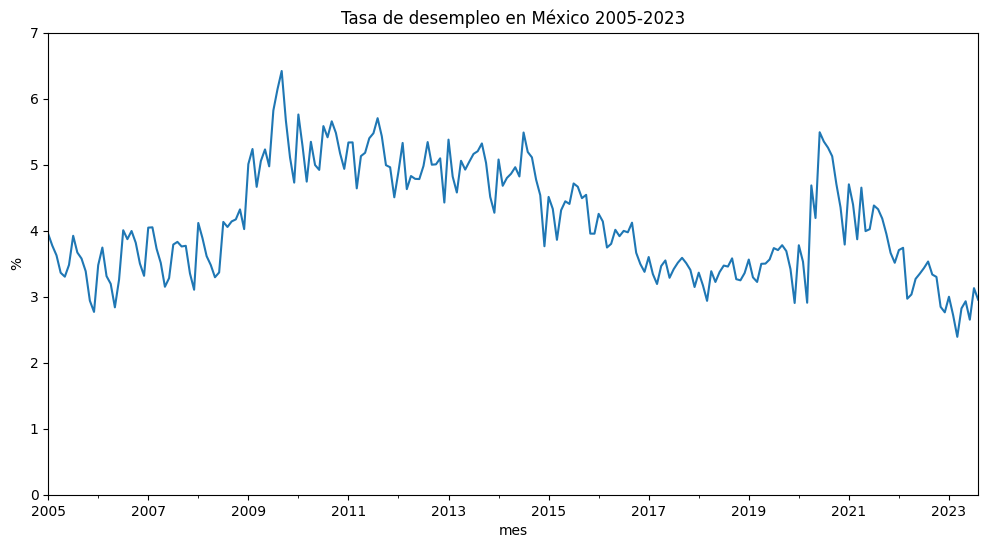

In [8]:
## Gráficamos la serie de tiempo
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('Tasa de desempleo en México 2005-2023')
plt.xlabel('mes')
plt.ylabel('%')
plt.ylim(0,7)
plt.show()

In [9]:
## Prueba de raíz unitaria 
prueba_adf = adfuller(desempleo_mex['tasa de desempleo'])
pvalue = prueba_adf[1]
pvalue.round(2)

0.25

No rechazamos Ho, significa que la tasa de desempleo es una serie no estacionaria.

In [10]:
## Aplicamos 1ras diferencias para convertirla a estacionaria
desempleo_mex['desempleo_diff'] = desempleo_mex['tasa de desempleo'].diff()

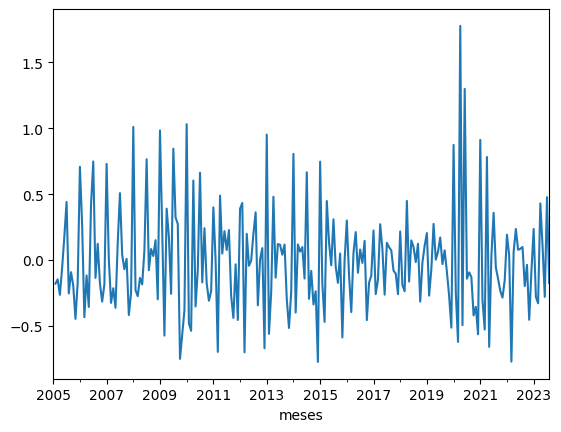

In [11]:
## Graficar primeras diferencias
desempleo_mex['desempleo_diff'].plot();

In [13]:
## Prueba de raíz unitaria para verificar que sea estacionaria
prueba_adf1 = adfuller(desempleo_mex['desempleo_diff'].dropna())
pvalue1 = prueba_adf1[1]
pvalue1.round(2)

0.01

Rechazamos Ho, significa que las primeras diferencias del desempleo es un proceso estacionario.

* Desempleo integrado de orden I(1)
* 1ras diferencias del desempleo integrado I(0)

### IDENTIFICAR EL ORDEN DEL PROCESO CON LAS GRÁFICAS DE CORRELACIÓN

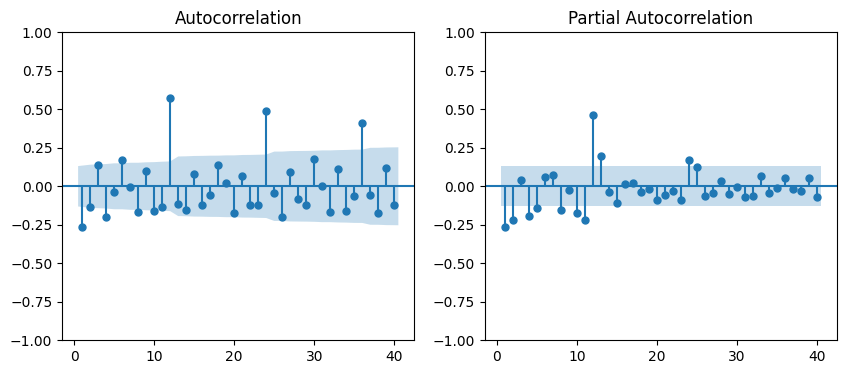

In [14]:
## Gráficas de correlación
ig, ax = plt.subplots(1,2, figsize=(10,4))
## 1er subgráfica
plot_acf(desempleo_mex['desempleo_diff'].dropna(), zero=False, lags=40, ax=ax[0])
## 2da subgráfica
plot_pacf(desempleo_mex['desempleo_diff'].dropna(), zero=False, lags=40, ax=ax[1])
plt.show()

Las gráficas de correlación muestran un patrón regular por lo tanto significa que estamos ante una serie con componente estacional; es decir, existen meses del año que la tasa de desempleo siempre sube y otros meses que la tasa de desempleo siempre baja. 

In [16]:
## Identificar el orden del ARIMA
pm.auto_arima(desempleo_mex['tasa de desempleo'],
              start_p=1,start_q=1,
              max_p=10,max_q=10,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1,start_Q=1,
              max_P=7,max_Q=7)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

La tasa de desempleo SARIMA(1,1,1)(1,0,1,12)

In [17]:
## Estimar el modelo 
model = ARIMA(desempleo_mex['tasa de desempleo'],
              order=(1,1,0),
              seasonal_order=(1,0,1,12))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Thu, 26 Oct 2023   AIC                             64.613
Time:                                    11:52:05   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [18]:
## Pronosticando el pasado
desempleo_mex['desempleo_arima'] = results.predict()

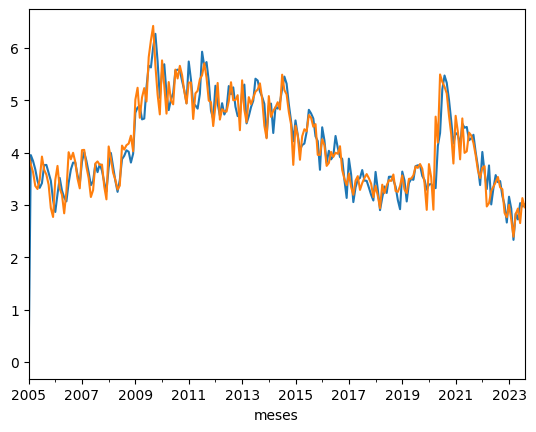

In [21]:
desempleo_mex['desempleo_arima'].plot()
desempleo_mex['tasa de desempleo'].plot()
plt.show()

In [24]:
desempleo_mex.tail()

,tasa de desempleo,desempleo_diff,desempleo_arima
meses,,,
2023-04-01,2.822799,0.430258,2.837606
2023-05-01,2.931125,0.108327,2.722100
2023-06-01,2.652033,-0.279093,3.034390
2023-07-01,3.129870,0.477837,2.968333
2023-08-01,2.955346,-0.174524,3.007014


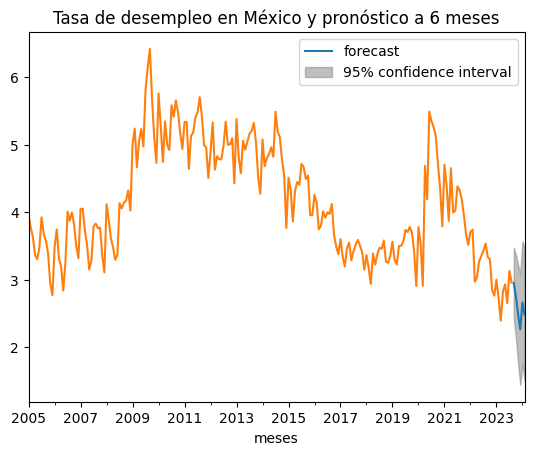

In [25]:
## Termina en agosto, pronosticamos en septiembre
plot_predict(results, '2023-09-01', '2024-02-01')
desempleo_mex['tasa de desempleo'].plot()
plt.title('Tasa de desempleo en México y pronóstico a 6 meses')
plt.show()

In [26]:
forecast = results.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [27]:
inicio = '2023-09-01'
fin = '2024-02-01'

In [28]:
pronostico_valor = forecast_mean[inicio:fin]
pronostico_intervalos = forecast_ci.loc[inicio:fin]

In [29]:
pronostico_valor

2023-09-01    2.951735
2023-10-01    2.750669
2023-11-01    2.483562
2023-12-01    2.262442
2024-01-01    2.661989
2024-02-01    2.481788
Freq: MS, Name: predicted_mean, dtype: float64

In [30]:
pronostico_intervalos

,lower tasa de desempleo,upper tasa de desempleo
2023-09-01,2.431389,3.472081
2023-10-01,2.135375,3.365962
2023-11-01,1.750115,3.217009
2023-12-01,1.439568,3.085317
2024-01-01,1.754472,3.569506
2024-02-01,1.498253,3.465323


In [31]:
## Juntar los dos pronósticos anteriores en un dataframe
df_forecast = pd.DataFrame({
'pronóstico':pronostico_valor,
'límite inferior':pronostico_intervalos.iloc[:,0],
'limite superior':pronostico_intervalos.iloc[:,1]
})

In [32]:
df_forecast

,pronóstico,límite inferior,limite superior
2023-09-01,2.951735,2.431389,3.472081
2023-10-01,2.750669,2.135375,3.365962
2023-11-01,2.483562,1.750115,3.217009
2023-12-01,2.262442,1.439568,3.085317
2024-01-01,2.661989,1.754472,3.569506
2024-02-01,2.481788,1.498253,3.465323


In [37]:
print(f'La tasa de desempleo pronosticada para septiembre de 2023 es {df_forecast.iloc[0,0].round(1)}%\nCon un 95% de confianza la tasa de desempleo está entre {df_forecast.iloc[0,1].round(1)}% y {df_forecast.iloc[0,2].round(1)}%')

La tasa de desempleo pronosticada para septiembre de 2023 es 3.0%
Con un 95% de confianza la tasa de desempleo está entre 2.4% y 3.5%


## Pronóstico del IPC BMV

In [63]:
ipc_bmv = pd.read_excel('ipc_bmv.xlsx')

In [64]:
ipc_bmv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-22,47485.738281,47672.921875,45677.269531,45803.328125,45803.328125,834808300
1,2018-10-29,45763.089844,45823.449219,43407.488281,45446.828125,45446.828125,1151016200
2,2018-11-05,45449.050781,46975.179688,42816.750000,44263.738281,44263.738281,1230024600
3,2018-11-12,44098.929688,44253.109375,41284.039063,42319.269531,42319.269531,1012842300
4,2018-11-19,41885.621094,42505.140625,41055.808594,41144.328125,41144.328125,558246700


In [65]:
ipc_bmv.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [66]:
ipc_bmv.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [67]:
## Como ya está en formato fecha, sólo nos falta el index y asignar la frecuencia

## Index
ipc_bmv = ipc_bmv.set_index('Date')
## Frecuencia
ipc_bmv = ipc_bmv.asfreq('W-MON')

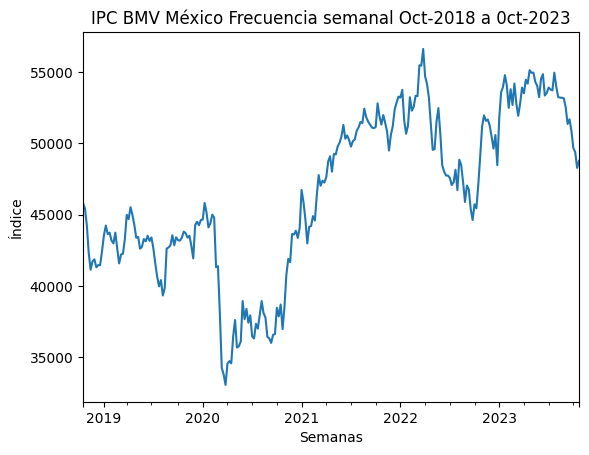

In [70]:
## Graficar
ipc_bmv['Adj Close'].plot()
plt.title('IPC BMV México Frecuencia semanal Oct-2018 a 0ct-2023')
plt.ylabel('Índice')
plt.xlabel('Semanas')
plt.show()

In [71]:
## Se parece a una caminata aleatoria, haremos prueba de raíz unitaria 
prueba_adf = adfuller(ipc_bmv['Adj Close'])
pvalue = prueba_adf[1]
pvalue.round(2)

0.54

No rechazamos, el IPC es una serie no estacionaria

In [72]:
## Para hacerla estacionaria aplicamos 1ras diferencias
ipc_bmv['ipc_diff'] = ipc_bmv['Adj Close'].diff()

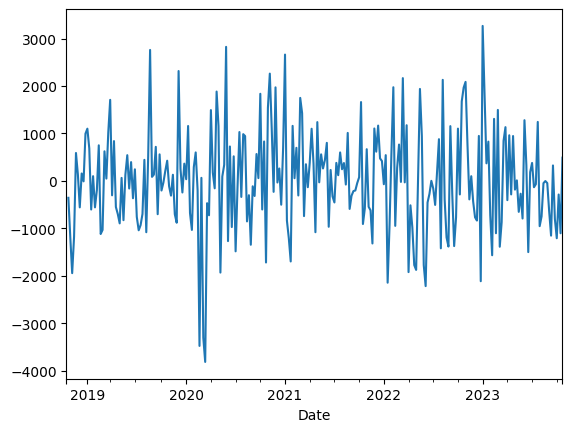

In [73]:
## Graficar 1ras diferencias
ipc_bmv['ipc_diff'].plot();

In [74]:
## Para confirmar, otra prueba de raíz unitaria 1ras diff IPC
prueba_adf1 = adfuller(ipc_bmv['ipc_diff'].dropna())
pvalue1 = prueba_adf1[1]
pvalue1.round(2)

0.0

Rechazamos Ho, significa que las primeras diferencias del IPC son una serie estacionaria 

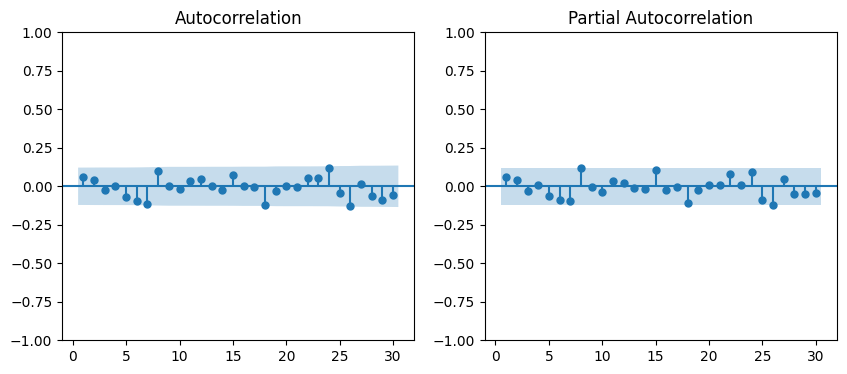

In [76]:
## Gráficas de correlación
ig, ax=plt.subplots(1,2, figsize=(10,4))
## 1er subgráfica 
plot_acf(ipc_bmv['ipc_diff'].dropna(), zero=False, lags=30, ax=ax[0])
##2da subgráfica
plot_pacf(ipc_bmv['ipc_diff'].dropna(), zero=False, lags=30, ax=ax[1])
plt.show()

El IPC es una serie que no tiene componente estacional, porque no observamos un patrón repetitivo en las correlaciones, todas permanecen en 0, las que nos importan son las que se salen del intervalo.

In [78]:
## Determinar el orden del ARIMA
pm.auto_arima(ipc_bmv['Adj Close'],
              start_p=1, start_q=1,
              max_p=7, max_q=7,
              ic='aic',
              seasonal=False)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Si tiene un 0 al inicio y un 0 al final significa que las primeras diferencias son un Ruido Blanco, éste proceso no se puede pronosticar. 

El IPC es un ARIMA (0,1,0), las primeras diferencias son un ARIMA (0,0,0) o lo que es lo mismo es un ruido blanco y por lo tanto no se podrían pronosticar con enfoque ARIMA 